![](http://pic1.tsingdataedu.com/%E9%87%8F%E5%8C%96banner.jpg)

# 用Python实现Mean Variance模型
#### [稀牛学院 x 网易云课程]《AI量化交易》

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize

读入数据，futures_price.csv文件包含四个期货品种的主力连续合约数据，时间段从2016年到2018年

In [2]:
#读入数据
futures=pd.read_csv("./data/futures_price.csv")
futures.head()

,Date,AU,CF,CS,CU
0,1/4/2016,228.2,11280,2050,35970
1,1/5/2016,230.3,11200,2076,36510
2,1/6/2016,231.4,11320,2081,36240
3,1/7/2016,236.6,11335,2036,36090
4,1/8/2016,236.8,11315,2046,35680


计算每个期货品种的daily return

In [3]:
data=futures.drop(['Date'],axis=1)

##计算return
return_vec=(data/data.shift(1)-1).dropna()
return_vec=return_vec.T
##资产的个数
n_assets = return_vec.shape[0]

daily return graph

Text(0,0.5,'returns')

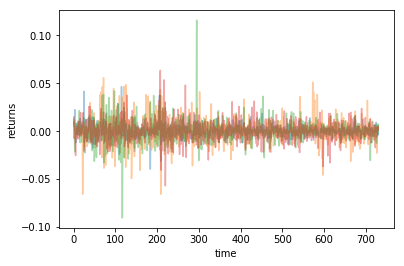

In [4]:
##return的图
plt.plot(return_vec.T, alpha=.4);
plt.xlabel('time')
plt.ylabel('returns')

生成一些随机的资产权重，并用这些权重计算投资组合的回报和波动率

In [5]:
def rand_weights(n):
    k = np.random.rand(n)
    return k / sum(k)

def get_portfolio_risk(weights,returns):
    C = np.asmatrix(np.cov(returns))
    weights=np.asmatrix(weights)
    sigma = np.sqrt(weights * C * weights.T)*np.sqrt(250)
    return sigma.item()

def get_portfolio_return(weights,returns):
    p = np.asmatrix(np.mean(returns, axis=1))
    mu=weights*p.T*250
    return mu.item()

def random_portfolio(returns):
    
    weights = np.asmatrix(rand_weights(returns.shape[0]))
    
    mu = get_portfolio_return(weights,returns)
    sigma = get_portfolio_risk(weights,returns)
    
    return mu, sigma

Text(0.5,1,'Mean and standard deviation of returns of randomly generated portfolios')

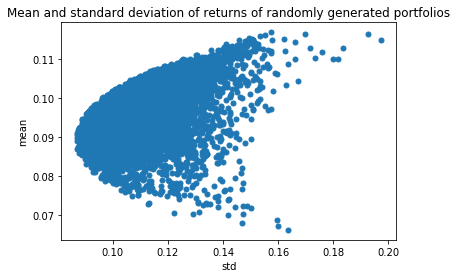

In [6]:
np.random.seed(123)
n_portfolios = 5000
means, stds = np.column_stack([random_portfolio(return_vec) for _ in xrange(n_portfolios)])

plt.plot(stds, means, 'o', markersize=5)
plt.xlabel('std')
plt.ylabel('mean')
plt.title('Mean and standard deviation of returns of randomly generated portfolios')

Case1：在不考虑无风险资产的情况下，求解Mean Variance最优化的资产权重

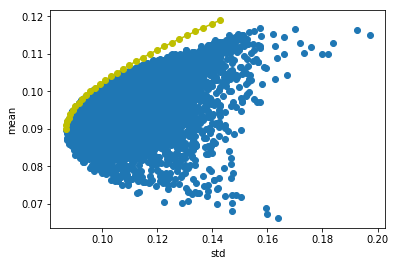

In [7]:
def optimize(returns, target_return=0.1):
    init_guess = np.ones(n_assets) * (1.0 / n_assets)
    weights = minimize(get_portfolio_risk, init_guess,
                       args=(returns,), method='SLSQP',
                       options={'disp': False},
                       constraints=({'type': 'eq', 'fun': lambda inputs: 1.0 - np.sum(inputs)},
                                    {'type': 'eq', 'args': (returns,),
                                     'fun': lambda inputs, returns:
                                     target_return - get_portfolio_return(weights=inputs,
                                                                          returns=returns)})                       )
    ret=get_portfolio_return(weights.x,returns)
    std=get_portfolio_risk(weights.x,returns)
    return ret, std

target_returns=np.arange(0.09,0.12,0.001)

returns,risks=np.column_stack([optimize(return_vec,target) for target in target_returns])

plt.plot(stds, means, 'o')
plt.ylabel('mean')
plt.xlabel('std')
plt.plot(risks, returns, 'y-o')

Case2：在考虑无风险资产的情况下，求解Mean Variance最优化的资产权重

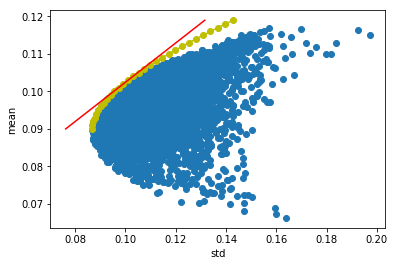

In [8]:
def get_portfolio_return_rf(weights,returns):
    p = np.asmatrix(np.mean(returns, axis=1))
    mu=weights*p.T
    ret=mu.item()*250+risk_free_rate*(1-np.sum(weights))
    return ret

def optimize_with_rf(returns, target_return=0.1):
    init_guess = np.ones(n_assets) * (1.0 / (n_assets+1))
    weights = minimize(get_portfolio_risk, init_guess,
                       args=(returns,), method='SLSQP',
                       options={'disp': False},
                       constraints=({'type': 'eq', 'args': (returns,),
                                     'fun': lambda inputs, returns:
                                     target_return - get_portfolio_return_rf(weights=inputs,
                                                                          returns=returns)})                       )
    ret=get_portfolio_return_rf(weights.x,returns)
    std=get_portfolio_risk(weights.x,returns)
    return ret, std



risk_free_rate=0.05
returns_rf,risks_rf=np.column_stack([optimize_with_rf(return_vec,target) for target in target_returns])

plt.plot(stds, means, 'o')
plt.ylabel('mean')
plt.xlabel('std')
plt.plot(risks, returns, 'y-o')
plt.plot(risks_rf, returns_rf, 'y',color='red')


### 版权归 © 稀牛学院 所有 保留所有权利
![](http://pic1.tsingdataedu.com/%E7%A8%80%E7%89%9B%20x%20%E7%BD%91%E6%98%93.png)